# Introducción

En este pequeño proyecto, desarrollaremos un modelo de clasificación con Machine Learning; nuestra información son algunos parámetros acerca del consumo de telefonía para algunos subscriptores de planes de la compañía Megaline. Debemos desarrollar un modelo con una exactitud del 75% al menos, e intentaremos con tres diferentes modelos para ver cual es el mejor en esta tarea: Árbol de decisión, Bosque Aleatorio, y de Regresión Logística.

## Trabajo previo
<a class="anchor" id="1"></a>

### Importar librerías
<a class="anchor" id="1.1"></a>
Importaremos pandas para leer los datos, numpy para trabajar con algunas fórmulas, pyplot para hacer gráficas con mejor control, seaborn para hacer un heatmap y algunos elementos de sklearn para nuestros modelos.

In [59]:
# Hagamos las importaciones necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### Trabajar con los datos
Carguemos y mostremos un sample de nuestro dataset, también algo de información importante

In [60]:
# Carguemos y mostremos
df_original = pd.read_csv("/datasets/users_behavior.csv")

display(df_original.sample(n=10, random_state=1))
print("\n----Info útil----\n")
df_original.info()

,calls,minutes,messages,mb_used,is_ultra
1719,62.0,545.53,3.0,4942.50,0
2922,74.0,498.09,97.0,16471.48,0
1895,93.0,630.74,54.0,13246.51,0
161,58.0,394.15,48.0,15605.44,0
255,40.0,225.89,12.0,13581.94,0
1089,51.0,371.83,63.0,5774.98,0
1463,7.0,22.96,7.0,12762.99,0
1009,84.0,608.19,19.0,25013.18,0
2322,134.0,933.89,91.0,12468.87,1
1126,93.0,628.59,41.0,19309.71,0



----Info útil----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Se ve todo en órden, no necesitamos hacer nada de limpieza o cambios. Ahora lo que haremos será separar el dataset en target y features, y hacer los conjuntos para entrenamiento, validación y testeo por separado: usaremos la regla de 60% para entrenamiento y 20% tanto para testeo y validación

In [61]:
# Separemos en target y feature el dataset
df_features = df_original.drop(["is_ultra"], axis=1)
df_target = df_original.is_ultra

# Hagamos el split en nuestros conjuntos de entrenamiento, test y validación. Lo hacemos en dos partes,
# el primero divide al 20% y el segundo al 25% para tomar de ese 80% (0.25*0.8 = 0.2 como se desea).
features_train, features_test, target_train, target_test  = train_test_split(
    df_features, df_target, test_size=0.2, random_state = 1
)

features_train, features_valid, target_train, target_valid  = train_test_split(
    features_train, target_train, test_size=0.25, random_state = 1
)

#Hagamos un simple chequeo de los rows para ver que todo anda en órden.
print(
    f"Feat | train: {features_train.shape[0]}, test: {features_test.shape[0]}, valid: {features_valid.shape[0]}"
)
print(
    f"Targ | train: {target_train.shape[0]}, test: {target_test.shape[0]}, valid: {target_valid.shape[0]}"
)

Feat | train: 1928, test: 643, valid: 643
Targ | train: 1928, test: 643, valid: 643


Todo se ve bien por acá, entonces podemos empezar a trabajar con diferentes modelos de machine learning.

## Modelos de machine learning

Utilizaremos tres modelos diferentes de aprendizaje para nuestros datos organizados. Probaremos con el modelo de árboles de decisión, de bosques aleatorios, y de regresión logística, y variaremos diferentes hiperpárametros cuando sea posible.

### Modelo de Árboles de decisión

El primer modelo a utilizar es el de árboles de decisión con el hiperpárametro la profundidad del modelo.

In [62]:
# Creamos un dataframe para guardar resultados
results_trees = pd.DataFrame([], columns=["depth", "accuracy"])

# Variemos los estimadores
for depth in tqdm(range(1, 20+1, 1)):
    model_trees= DecisionTreeClassifier(max_depth = depth, random_state=1)
    model_trees.fit(features_train, target_train)

    prediction_trees = model_trees.predict(features_valid)

    results_trees = results_trees.append(
        {
            "depth": depth,
            "accuracy": accuracy_score(target_valid, prediction_trees)
        },
        ignore_index=True
    )

  0%|          | 0/20 [00:00<?, ?it/s]

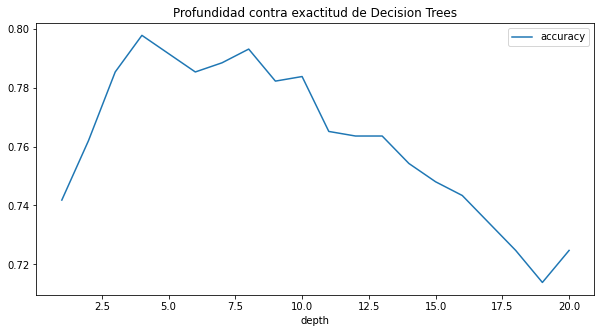

In [63]:
results_trees.plot(x="depth", y="accuracy", figsize=(10,5))
plt.title("Profundidad contra exactitud de Decision Trees")
plt.show()

Tenemos una buena exactitud con este modelo, aunque es un poco simple, note que es curioso que la mayor exactitud se pierde con una mayor profundidad.

### Modelo de Bosque Aleatorio
Como tenemos libertad con el tiempo de cómputo, variaremos los hiperpárametros _depth_ y _estimators_ para encontrar la mejor opción. Los guardaremos en una tabla y dibujaremos un heatmap para comparar accuracy.

In [64]:
# Creamos un dataframe para guardar resultados
results_random_trees = pd.DataFrame([], columns=["depth", "estimators", "accuracy"])

# Hagamos los dos loops anidados para los hiper párametros, usemos tqdm para llevar track del tiempo
for depth in tqdm(range(1, 20+1, 1)):
    for est in range(10, 100+1, 10):
        model_random_trees = RandomForestClassifier(n_estimators = est, max_depth=depth, random_state=1)
        model_random_trees.fit(features_train, target_train)
        
        prediction_random_trees = model_random_trees.predict(features_valid)
        
        results_random_trees = results_random_trees.append(
            {
                "depth": depth,
                "estimators": est,
                "accuracy": accuracy_score(target_valid, prediction_random_trees)
            },
            ignore_index=True
        )

  0%|          | 0/20 [00:00<?, ?it/s]

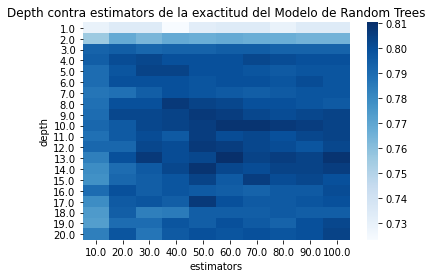

In [65]:
#results_random_trees.heatmap()
#sns.heatmap(results_random_trees.pivot("depth", "estimators", "accuracy"))

pivot_random_trees = results_random_trees.pivot_table(
    columns="estimators", index = "depth", values="accuracy"
)

sns.heatmap(pivot_random_trees, cmap="Blues")

plt.title("Depth contra estimators de la exactitud del Modelo de Random Trees")
plt.show()

Como podemos ver de los resultados, la diferencia no es muy grande entre el valor más bajo y el más alto; si quisieramos tomar este último podríamos pecar de sobreajustar nuestros modelo y sería mejor en todo caso irnos por la justa medianía. Observese que en el caso de una profundidad de 8, con 40 estimadores es uno de los que mejor exactitud tiene. Veamos ese dato.

In [66]:
pivot_random_trees[40][8]

0.807153965785381

Tenemos una exactitud de casi el 81% para este modelo tan simple, vamos por buen puerto. No elegimos valores más altos de exactitud porque podríamos arriesgarnos a sobreajustar por una diferencia ínfima de mejoría.

### Modelo de Regresión logística

Ahora toca el último modelo, de regresión logística, el cual no tiene hiperpárametros (el solver y penalty realmente no lo son, aunque pueden modificarse).

In [67]:
# Creamos un dataframe para guardar resultados
results_logistic = pd.DataFrame([], columns=["depth", "estimators", "accuracy"])

model_logistic =  LogisticRegression ()

model_logistic.fit(features_train, target_train)
prediction_logistic = model_logistic.predict(features_valid)
        
accuracy_score(target_valid, prediction_logistic)

0.7558320373250389

Notemos que el modelo de regresión logística no es particularmente exacto, el _accuracy_score_ no es muy alto, aunque la rapidez de entrenamiento es alta y el procedimiento es bastante sencillo.

## Datos de prueba

Hemos trabajado con tres modelos hasta el momento, y el que obtuvimos que parece ser el mejor candidato es el Modelo de Bosque Aleatorio con profundidad 8 y 40 estimadores. Entremos este modelo con el dataset ampliado de los datos de entrenamiento y validación (para tener mejor exactitud), y hagamos la predicción con nuestros datos de prueba.

In [68]:
# Usemos el modelo contemplado
final_model = RandomForestClassifier(n_estimators = 8, max_depth=40, random_state=1)
final_model.fit(
    pd.concat([features_train, features_valid], axis=0),
    pd.concat([target_train, target_valid], axis=0)
)

# Hagamos la predicción
prediction_final = final_model.predict(features_test)

print(
    f"Tenemos una exactitud de {accuracy_score(target_test, prediction_final)*100:.4f}% para el conjunto de prueba."
)


Tenemos una exactitud de 79.4712% para el conjunto de prueba.


Nuestro modelo ha bajado un poco su exactitud al ser utilizado, pero sigue siendo mayor que el 75% mínimo deseable. Es un resultado positivo para nuestro modelo.

## Conclusiones

Hemos dividido nuestro dataset en tres grupos: entrenamiento, validación y prueba. Probamos diversos modelos y notamos que el de Bosques Aleatorios tiene la mejor relación entre exactitud y rapidez de entrenamiento. También no parece que este sobreajustado, aunque al hacer la prueba hubo una pequeña reducción en la exactitud (algo completamente normal en todo caso).